In [1]:
from keras.models import Sequential
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.models import Model,load_model
from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform
from keras.engine.topology import Layer
from keras import backend as K
K.set_image_data_format('channels_first')

import cv2
import os
import numpy as np
from numpy import genfromtxt
import tensorflow as tf
from fr_utils import *
from inception_blocks_v2 import *
import sklearn
import sys
import gc
import json
import shutil

from pydub import AudioSegment
import random
import io
import glob
from td_utils import *

import pyaudio
from pyaudio import PyAudio, paInt16 
from datetime import datetime 
import wave

%matplotlib inline
%load_ext autoreload
%autoreload 2


Using TensorFlow backend.
D:\Anaconda_app\envs\tensorflow-gpu\lib\site-packages\pydub\utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


# 1、load models

In [6]:
%time FRmodel = faceRecoModel(input_shape=(3, 96, 96))
#print("Total Params:", FRmodel.count_params())
#FRmodel.compile(optimizer = 'adam', loss = triplet_loss, metrics = ['accuracy'])
%time load_weights_from_FaceNet(FRmodel)

Wall time: 1min 16s


In [2]:
audio_model = load_model('tr_model.h5')

D:\Anaconda_app\envs\tensorflow-gpu\lib\site-packages\keras\engine\saving.py:304: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


# 2、face record and recognition

## for face detection and recognition

In [7]:
IMAGE_SIZE = 96
def resize_image(image, height = IMAGE_SIZE, width = IMAGE_SIZE):
    top, bottom, left, right = (0, 0, 0, 0)
    
    #获取图像尺寸
    h, w, _ = image.shape
    
    #对于长宽不相等的图片，找到最长的一边
    longest_edge = max(h, w)    
    
    #计算短边需要增加多上像素宽度使其与长边等长
    if h < longest_edge:
        dh = longest_edge - h
        top = dh // 2
        bottom = dh - top
    elif w < longest_edge:
        dw = longest_edge - w
        left = dw // 2
        right = dw - left
    else:
        pass 
    
    #RGB颜色
    BLACK = [0, 0, 0]
    
    #给图像增加边界，是图片长、宽等长，cv2.BORDER_CONSTANT指定边界颜色由value指定
    constant = cv2.copyMakeBorder(image, top , bottom, left, right, cv2.BORDER_CONSTANT, value = BLACK)
    
    #调整图像大小并返回
    return cv2.resize(constant, (height, width))


    
def findNearestClassForImage(face_descriptor,faceLabel):
    temp =  face_descriptor - data
    e = np.linalg.norm(temp,axis=1,keepdims=True)
    min_distance = e.min() 
    #print('distance: ', min_distance)
    if min_distance > threshold:
        return 'other'
    index = np.argmin(e)
    return faceLabel[index]

def max_list(lt):    
    temp = 0    
    for i in lt:        
        if lt.count(i) > temp:            
            max_str = i            
            temp = lt.count(i)    
            return max_str

# k nearest or just the most when bigger than threshold?
def find_KNearestClassForImage(face_descriptor,data, faceLabel,threshold=0.54):
    temp =  face_descriptor - data
    e = np.linalg.norm(temp,axis=1,keepdims=True)
    sequence = np.argsort(e.reshape(1,-1))
    mask = e>threshold
    Label = np.array(faceLabel)        
    names= Label[np.squeeze(mask)]
    return max_list(names.tolist())

## face record

In [8]:
#-*- coding: utf-8 -*-
# save the photos

if __name__ == '__main__':

    # open data and label file
    labelFile=open('label.txt','r')
    label = json.load(labelFile)                                                   #载入本地人脸库的标签
    labelFile.close()   
    data = np.loadtxt('faceData.txt',dtype=float)  
    
    # threshold of recognising photo
    threshold = 0.54
    # later save into label name
    name = input('Please input your name: ')
   
    font=cv2.FONT_HERSHEY_SIMPLEX           
    #框住人脸的矩形边框颜色       
    color = (0, 255, 0)
    
    #count pic, if test pics
    cnt_p = 0 
    
    #捕获指定摄像头的实时视频流
    cap = cv2.VideoCapture(0)#int(sys.argv[1]))
    
    #人脸识别分类器本地存储路径
    cascade_path='D:\\WM\\AI learning\\Ng - Deep Learning\\course4\\face recognistion\\haarcascade_frontalface_alt2.xml'
    #cascade_path = 'D:\\WM\\haarcascade_frontalface_alt2.xml'
    
    while True:
        ret, frame = cap.read()   #读取一帧视频
        
        #图像灰化，降低计算复杂度
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            # kk is the return value of cv2.waitKey; the value is what user input
        kk = cv2.waitKey(1)

        #图像灰化，降低计算复杂度
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        #使用人脸识别分类器，读入分类器
        cascade = cv2.CascadeClassifier(cascade_path)                

        #利用分类器识别出哪个区域为人脸
        faceRects = cascade.detectMultiScale(frame_gray, scaleFactor = 1.2, minNeighbors = 3, minSize = (32, 32))        
        if len(faceRects) > 0:                 
            for faceRect in faceRects: 
                x, y, w, h = faceRect

                # if user input 's' ,then save pic
                if kk == ord('s'):

                    #截取脸部图像提交给模型识别这是谁
                    image = frame[y: y + h-5, x+10 : x + w -20]
                    image = resize_image(image)
                    embeddings = image_to_encoding(image, FRmodel) 
                    #save image matrix and label 
                    data = np.concatenate((data, embeddings))                                                
                    label.append(name) 

                    '''
                    # test photo size
                    path_make_dir = "imgs/img/"
                    cnt_p += 1
                    cv2.imwrite(path_make_dir + "/img_face_" + str(cnt_p) + ".jpg", image)
                    print("write：", str(path_make_dir) + "/img_face_" + str(cnt_p) + ".jpg")
                    '''

                cv2.rectangle(frame, (x - 10, y - 10), (x + w +10, y + h +10), color, thickness = 2)
                cv2.putText(frame, "Faces: " + str(len(faceRects)), (20, 100), font, 0.8, (0, 255, 0), 1, cv2.LINE_AA)

                # 添加说明
                cv2.putText(frame, "Face Register", (20, 40), font, 1, (255, 255, 255), 1, cv2.LINE_AA)
                #cv2.putText(im_rd, "N: New face folder", (20, 350), font, 0.8, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(frame, "S: Save face", (20, 400), font, 0.8, (255, 255, 255), 1, cv2.LINE_AA)
                cv2.putText(frame, "Q: Quit", (20, 450), font, 0.8, (255, 255, 255), 1, cv2.LINE_AA)

    # 按下 'q' 键退出
        if kk & 0xFF== ord('q'):
            break    


        cv2.imshow("Identify you", frame)
        '''        
        #等待10毫秒看是否有按键输入
        k = cv2.waitKey(10)
        #如果输入q则退出循环
        if k & 0xFF == ord('q'):
            break
        '''  
    np.savetxt('faceData.txt', data, fmt='%f')                                                          #保存人脸特征向量合成的矩阵到本地

    labelFile=open('label.txt','w')                                      
    json.dump(label, labelFile)                                                                         #使用json保存list到本地
    labelFile.close()
    #释放摄像头并销毁所有窗口
    cap.release()
    cv2.destroyAllWindows()


Please input your name: a


In [13]:
#-*- coding: utf-8 -*-
# recognize

def recognize():
    labelFile=open('label.txt','r')
    label = json.load(labelFile)                                                   #载入本地人脸库的标签
    labelFile.close()
    threshold = 0.54
    data = np.loadtxt('faceData.txt',dtype=float)  
    #model = Model()
    #model.load_model(file_path = './model/me.face.model.h5')    
               
    #框住人脸的矩形边框颜色       
    color = (0, 255, 0)
    
    #捕获指定摄像头的实时视频流
    cap = cv2.VideoCapture(0)#int(sys.argv[1]))
    
    #人脸识别分类器本地存储路径
    
    cascade_path = 'D:\\WM\\AI learning\\Ng - Deep Learning\\course4\\face recognistion\\haarcascade_frontalface_alt2.xml'
    #D:\\WM\\AI learning\\Ng - Deep Learning\\course4\\face recognistion\\haarcascade_frontalface_alt2.xml

    while True:
        ret, frame = cap.read()   #读取一帧视频
        

        #图像灰化，降低计算复杂度
        frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        #使用人脸识别分类器，读入分类器
        #cascade = cv2.CascadeClassifier("D:\\WM\\AI learning\\Ng - Deep Learning\\course4\\face recognistion\\haarcascade_frontalface_alt2.xml")
        cascade = cv2.CascadeClassifier(cascade_path)                

        #利用分类器识别出哪个区域为人脸
        faceRects = cascade.detectMultiScale(frame_gray, scaleFactor = 1.2, minNeighbors = 3, minSize = (32, 32))        
        if len(faceRects) > 0:                 
            for faceRect in faceRects: 
                x, y, w, h = faceRect
                
                #截取脸部图像提交给模型识别这是谁
                image = frame[y - 10: y + h + 10, x - 10: x + w + 10]
                image = resize_image(image)

                embeddings = image_to_encoding(image, FRmodel) 
                class_pre = find_KNearestClassForImage(embeddings, data,label)  
                #class_pre =findNearestClassForImage(embeddings,label)
                
                                                     
                cv2.rectangle(frame, (x - 10, y - 10), (x + w + 10, y + h + 10), color, thickness = 2)
                    
                #文字提示是谁
                cv2.putText(frame,class_pre, 
                            (x + 30, y + 30),                      #坐标
                            cv2.FONT_HERSHEY_SIMPLEX,              #字体
                            1,                                     #字号
                            (255,0,255),                           #颜色
                            2)                                     #字的线宽

                            
        cv2.imshow("Identify you", frame)
                  
        #等待10毫秒看是否有按键输入
        k = cv2.waitKey(10)
        #如果输入q则退出循环
        if k & 0xFF == ord('q'):
            break

    #释放摄像头并销毁所有窗口
    cap.release()
    cv2.destroyAllWindows()


## for word triggering

In [10]:
CHUNK = 1024
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 16000
RECORD_SECONDS = 2

# record and export to .wav
def rec(file_name):
    p = pyaudio.PyAudio()

    stream = p.open(format=FORMAT,
                    channels=CHANNELS,
                    rate=RATE,
                    input=True,
                    frames_per_buffer=CHUNK)

    print("say something.")

    frames = []

    for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
        data = stream.read(CHUNK)
        frames.append(data)

    print("shut up")

    stream.stop_stream()
    stream.close()
    p.terminate()

    wf = wave.open(file_name, 'wb')
    wf.setnchannels(CHANNELS)
    wf.setsampwidth(p.get_sample_size(FORMAT))
    wf.setframerate(RATE)
    wf.writeframes(b''.join(frames))
    wf.close()
    
    
# process the wav into 10s length
def preprocess_audio(filename):
    # Trim or pad audio segment to 10000ms
    padding = AudioSegment.silent(duration=10000)
    segment = AudioSegment.from_wav(filename)[:10000]
    #print(segment[0:10])
    segment = padding.overlay(segment)
    # Set frame rate to 44100
    segment = segment.set_frame_rate(44100)
    # Export as wav
    segment.export(filename, format='wav')
    
# Load a wav file
def get_wav_info(wav_file):
    rate, data = wavfile.read(wav_file)
    return rate, data

# turn into shape (5511,)
def graph_spectrogram(wav_file):
    rate, data = get_wav_info(wav_file)
    nfft = 200 # Length of each window segment
    fs = 8000 # Sampling frequencies
    noverlap = 120 # Overlap between windows
    nchannels = data.ndim
    if nchannels == 1:
        pxx, freqs, bins, im = plt.specgram(data, nfft, fs, noverlap = noverlap)
    elif nchannels == 2:
        pxx, freqs, bins, im = plt.specgram(data[:,0], nfft, fs, noverlap = noverlap)
    return pxx

#predict if triggerword
def detect_triggerword(filename):
    plt.subplot(2, 1, 1)

    x = graph_spectrogram(filename)
    # the spectogram outputs (freqs, Tx) and we want (Tx, freqs) to input into the model
    x  = x.swapaxes(0,1)
    x = np.expand_dims(x, axis=0)
    predictions = audio_model.predict(x)
    

    plt.subplot(2, 1, 2)
    plt.plot(predictions[0,:,0])
    plt.ylabel('probability')
    plt.show()

    return predictions


# run recognition if trigger word detected    
def run_on_activate(predictions, threshold):

    Ty = predictions.shape[1]
    # Step 1: Initialize the number of consecutive output steps to 0
    consecutive_timesteps = 0
    # Step 2: Loop over the output steps in the y
    for i in range(Ty):
        # Step 3: Increment consecutive output steps
        consecutive_timesteps += 1
        # Step 4: If prediction is higher than the threshold and more than 75 consecutive output steps have passed
        if predictions[0,i,0] > threshold and consecutive_timesteps > 75:
            # Step 5: Open face recognition
            #print('you are right')
            recognize()
            running = False
            break

        else:
            running = True
    return running



say something.
shut up


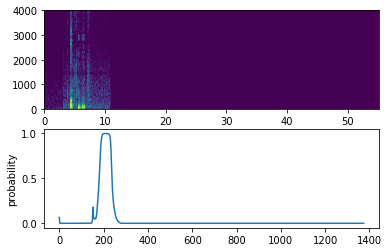

In [14]:
if __name__ == "__main__":
    running = True
    while running:
        rec("temp.wav") 
        your_filename = "temp.wav"        
        test=graph_spectrogram(your_filename)
        while test.shape[1]!=5511:
            preprocess_audio(your_filename)
            test=graph_spectrogram(your_filename)
        prediction = detect_triggerword(your_filename)
        running = run_on_activate(prediction, 0.5)